## First computer exercise in Machine Learning: Unsupervised methods
==============================================================================================================


Make sure you have all the packages first.

In [1]:
import numpy as np
import sklearn.datasets as ds
import matplotlib.pyplot as plt 
import mdp
from course_utils import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans

Prepare the data. Unzip the compressed ini_data and mnist folders.

## Part A: Principal Component Analysis

Write a function that performs PCA on a (not necessarily centered) data in a 2D numpy array. The function should return the pca transformed data along with the eigenvalues and eigenvectors of the tranformation. Use the numpy package. 

In [2]:
# Hint: Use this code snippet to find eigenvectors
#       and eigenvalues of an array and return them 
#       in an order of descending eigenvalues
E, V = np.linalg.eig(np.array([[0, 2],
                               [1, 1]]))
key = np.argsort(E)[::-1]
V = V[:,key]
E = E[key]
print(E)
print(V)

[ 2. -1.]
[[-0.70710678 -0.89442719]
 [-0.70710678  0.4472136 ]]


In [100]:
def principal_component_analysis(data, pca_components=2):
    """
    PCA with eigenvalues
    
    :param data: A 2d numpy array where data.shape == (number_of_data_points, dimensionality_of_data_points)
    :returns: tuple (U, E, V) 
        WHERE
        U is a numpy array of the pca transformed data
        E is an descending numpy array of the eigenvalues of the covariance matrix
        V is an array of eigenvectors of the cov. matrix such that eigenvalue E[i] corresponds to V[i,:]
    """
    ### YOUR CODE STARTS HERE ###
    
    m, n = data.shape
    data -= data.mean(axis=0)
    R = np.cov(data, rowvar=False)
    #R = (1.0 / XX.shape[0]) * np.dot(XX, XX.T)
    evals, evecs = np.linalg.eig(R)
    
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    E = evals[idx]
    V = evecs[:, :pca_components]
    
    
    U = np.dot(V.T, data.T).T
    V = np.transpose(V)
    #print(E)
    #print(V)
    ### YOUR CODE ENDS HERE ###
    return (U, E, V)

We will begin with the MNIST handwritten digit image data set https://en.wikipedia.org/wiki/MNIST_database.

(70000, 784)
(70000,)


/home/hlynur/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/home/hlynur/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


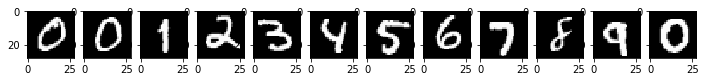

In [4]:
dataset = ds.fetch_mldata('MNIST original', data_home="./mnist")
XX, YY = dataset["data"].astype('float'), np.array(dataset["target"]).astype('float')
print(XX.shape)
print(YY.shape)
plt.figure(figsize=(12, 12))
for i in range(12):
    plt.subplot(1, 12, i+1)
    plt.imshow(np.reshape(XX[int(i*5500),:], (28, 28)), cmap="gray")
plt.show()

Check that your function outputs a solution that agrees with the canonical python implementation of PCA

In [101]:
(U, E, V) = principal_component_analysis(XX, 2)
pca = PCA(n_components=2)
pca.fit(XX)
if np.transpose(V).shape == pca.components_.shape:
    print("Try transposing your eigenvector output")
assert(np.allclose([1, 1], np.abs(np.diagonal(np.inner(V, pca.components_)))))
print("Passed")

Passed


See how the MNIST data set looks like with $n=2$ PCA components:

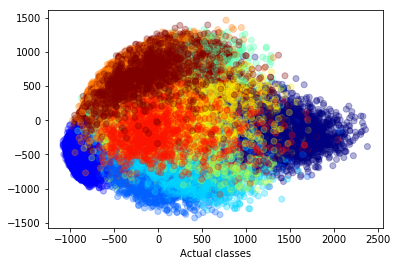

In [6]:
pca_features, _, V = principal_component_analysis(XX, 2)
plt.xlabel('Actual classes')
plt.scatter(pca_features[:,0], pca_features[:,1], c=YY, alpha=0.3, cmap="jet")
plt.show()

Visualize the principal components of the MNIST data set for $n=10$ components.

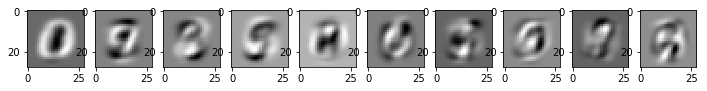

In [7]:
pca_features, _, V = principal_component_analysis(XX, 10)
plt.figure(figsize=(12, 12))

for i in range(10):
    plt.subplot(1, 10, i+1)
    comp_image = np.reshape(V[i,:], (28,28))
    plt.imshow(comp_image.astype('float'), cmap="gray")
plt.show()

Do a similar visualization for a reduced version of the German Traffic Sign Recognition Benchmark, distributed by the INI

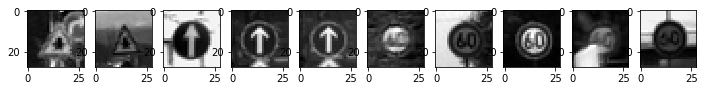

In [8]:
X, Y = load_ini_data2()
ini_clusters = len(np.unique(Y))
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(np.reshape(X[int(i*110),:], (28, 28)), cmap="gray")
plt.show()

Visualize the data set:

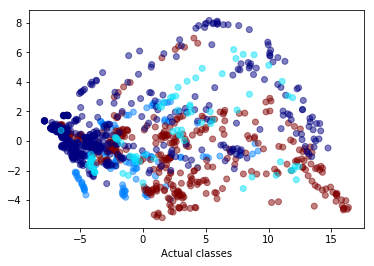

In [9]:
pca_features, _, V = principal_component_analysis(X, 2)
plt.xlabel('Actual classes')
plt.scatter(pca_features[:,0], pca_features[:,1], c=Y, alpha=0.5, cmap="jet")
plt.show()

Visualize the "eigensigns".

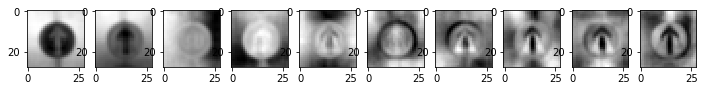

In [10]:
pca_features, _, V = principal_component_analysis(X, 10)
plt.figure(figsize=(12, 12))

for i in range(10):
    plt.subplot(1, 10, i+1)
    comp_image = np.reshape(V[i,:], (28, 28))
    plt.imshow(comp_image, cmap="gray")
plt.show()

## Part B: Whitening
Use your PCA implemention to complete this whitening function.

In [11]:

def whiten(data):
    """
    Whitening

    :param data: A 2d numpy array of where data.shape == (number_of_data_points,
                 dimensionality_of_data_points), assume that the data is centered
    :returns: tuple (whitened_data, whitening_matrix) 
        WHERE
        whitened_data is the transformed input data whose covariance is the identity matrix
        whitening_matrix is the transformation that yields the whitening: 
                         np.dot(whitening_matrix, data.T) == whitened_data.T
    """

    ### YOUR CODE STARTS HERE ###
    X = np.array(data)
    pca = PCA(n_components=X.shape[1])
    pca.fit(X)

    (U, E, V) = principal_component_analysis(X, X.shape[1])
    Lambda = np.zeros((len(pca.singular_values_), len(pca.singular_values_)))
    np.fill_diagonal(Lambda, np.power(E, -0.5))
    X = np.dot(np.dot(Lambda, V), X.T)
    whitened_data = X
    whitening_matrix = np.dot(Lambda, V)
    ### YOUR CODE ENDS HERE ###
    
    return (whitened_data, whitening_matrix)

Identity covariance test:

In [12]:
rnd_data = np.random.multivariate_normal([0, 0], [[3, 4], [5, 6]], 1000)
print(rnd_data.shape)
whitened_data, whitening_matrix = whiten(rnd_data)
assert(np.allclose(np.identity(2), np.cov(whitened_data)))
print("Passed")

(1000, 2)
Passed


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """Entry point for launching an IPython kernel.


Data recovery test:

In [13]:
inverse_whitening = np.linalg.inv(whitening_matrix)
recovered_data = np.dot(inverse_whitening, whitened_data)
if recovered_data.shape != rnd_data.shape:
    recovered_data = recovered_data.T
assert(np.allclose(rnd_data, recovered_data, atol=0.2))
print("Passed")

Passed


Inspect the effect of whitening

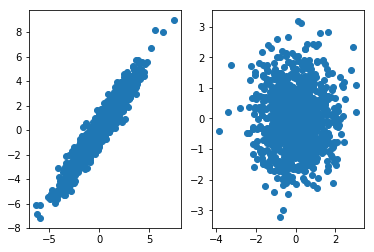

In [14]:
plt.subplot(1, 2, 1)
plt.scatter(rnd_data[:,0], rnd_data[:,1])
if rnd_data.shape != whitened_data.shape:
    whitened_data = whitened_data.T
plt.subplot(1, 2, 2)
plt.scatter(whitened_data[:,0], whitened_data[:,1])
plt.show()


## Part C: Slow Feature Analysis

Use your PCA and whitening functions to implement SFA.

In [15]:
def slow_feature_analysis(data, n_features):
    """
    Slow Feature Analysis
    
    :param data: A numpy array where data.shape == (number_of_data_points, dimensionality_of_data_points)
    :param n_features: The number of slowest features to calculate for each point
    
    :returns sfa_transformed_data: An array of the sfa transformed data with shape (data.shape[0], n_features)
    """
    ### YOUR CODE STARTS HERE ###
    whitened_data, _ = whiten(data)
    whitened_data = whitened_data.T
    derivative = lambda Z: Z[1:, :]-Z[:-1, :]
    whitened_derivatives = derivative(whitened_data)
    (U, E, V) = principal_component_analysis(whitened_derivatives, data.shape[1])
    sfa_transformed_data = whitened_data.dot(V[-n_features:,:].T)
    sfa_transformed_data = np.fliplr(sfa_transformed_data)
    ### YOUR CODE ENDS HERE ###
    return sfa_transformed_data


Identity covariance test:

In [16]:
sfa_dims = 2
rnd_data = np.random.multivariate_normal([0, 0], [[3, 4], [5, 6]], 1000)
sfa_homemade = slow_feature_analysis(rnd_data, sfa_dims)
assert(np.allclose(np.identity(2), np.cov(sfa_homemade.T)))
print("Passed")

Passed


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  


Slowness test:

In [17]:
def calculate_deltas(feature_array):
    derivatives = feature_array[1,:] - feature_array[:-1,]
    power = np.power(derivatives, 2) 
    return np.mean(power, axis=0)
sfa = mdp.nodes.SFANode(output_dim=sfa_dims)
sfa_mdp = sfa.execute(rnd_data)
assert(np.allclose(calculate_deltas(sfa_homemade), calculate_deltas(sfa_mdp)))
print("Passed")

Passed


Visualize the SFA-transformed traffic sign data. 

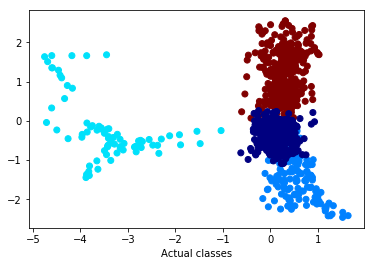

In [18]:
slow_features = slow_feature_analysis(X, 2)
plt.scatter(slow_features[:,0], slow_features[:,1], c=Y, cmap="jet")
plt.xlabel("Actual classes")
plt.show()

## Part D: K-Means clustering
Complete this function that calculates the reconstruction error of a clustering assignment according to the lecture notes.


In [53]:
def km_error(data, centroids, assignment):
    """
    K-Means error
    
    :param data: A 2D numpy array where data.shape == (number_of_data_points, dimensionality_of_data)
    :param centroids: A 2D numpy array where centroids.shape == (n_clusters, dimensionality_of_data)
    :param assignment: A list defining the allocation of the data to clusters such that data[i,:] belongs to
                       cluster assignment[i], corresponding to centroids[clustering[i]]
                       assume that the cluster labels are integers in 0, ..., n_clusters
    
    :returns total_error: The reconstruction error of the clustering (eq. 1 lecture notes on clustering)
    """
    ### YOUR CODE STARTS HERE ###
    total_error = 0
    for i in range(data.shape[0]):
        total_error += np.linalg.norm(data[i,:] - centroids[int(assignment[i])])**2
    ### YOUR CODE ENDS HERE ###
    return total_error 

Test km_error:

In [54]:
kmeans = KMeans(init='random', n_clusters=5)
rnd_data = np.random.multivariate_normal([0,0], [[1, 0], [0, 1]], 100)
kmeans.fit(rnd_data)
assert(np.allclose(kmeans.inertia_, km_error(rnd_data, kmeans.cluster_centers_, kmeans.labels_)))
print("Passed")

Passed


Now write a function that calculates the optimal choice of cluster centers:

In [60]:
def km_centers(data, assignment, n_clusters):
    """
    K-Means centroids
    
    :param data: A 2D numpy array where data.shape == (number_of_data_points, dimensionality_of_data)
    :param assignment: A list defining the allocation of the data to clusters such that data[i,:] belongs to
                       cluster assignment[i]
                       assume that the cluster labels are integers in 0, ..., n_clusters
    :param n_clusters: the upper bound on the values that the elements in assignment can take
    
    :returns centroids: A 2D numpy array where centroids.shape == (n_clusters, dimensionality_of_data),
                        calculated according to eq. 2 in the lecture notes on clustering
    
    """
    ### YOUR CODE STARTS HERE ###
    centroids = np.zeros((n_clusters, data.shape[1]))
    N = np.zeros(n_clusters)
    for i in range(len(N)):
        N[i] = np.sum(1 for j in assignment if j == i)
    for i in range(data.shape[0]):
        centroids[int(assignment[i])] += data[i,:]
    for i in range(n_clusters):
        for j in range(data.shape[1]):
            centroids[i,j]/=N[i] 
    ### YOUR CODE ENDS HERE ###
    return centroids


Test km_centers:

In [57]:
kmeans = KMeans(init='random', n_clusters=5)
rnd_data = np.random.multivariate_normal([0,0], [[1, 0], [0, 1]], 100)
kmeans.fit(rnd_data)
assert(np.allclose(kmeans.cluster_centers_, km_centers(rnd_data, kmeans.labels_, 5)))
print("Passed")

Passed


/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


Write a k-means clustering algorithm that gets a numpy array of data, along with a number $k$ of clusters and a convergence threshold. Use the previous two functions you wrote above and choose the initial center locations randomly from the data points.

In [110]:
def k_means(data, n_clusters, threshold):
    """
    K-Means Clustering
    
    :param data: A 2d numpy array where data.shape == (number_of_data_points, dimensionality_of_data_points)
    :param n_clusters: The number of clusters the algorithm finds
    :param threshold: The minimum change in eq. 1 (lecture notes on clustering) before algorithm stops 
    :returns assignment: a list of class assignments such that point data[i,:] belongs to cluster assignment[i]
    """
    
    ### YOUR CODE STARTS HERE ###
    N = data.shape[0]
    centroids = np.zeros((n_clusters, data.shape[1]))
    for i in range(n_clusters):
        random_center_index = np.random.randint(0, N)
        centroids[i,:] = data[random_center_index, :] 
    assignment = np.zeros((N))
    for i in range(N):
        assignment[i] = int(i % n_clusters)
    
    change = np.infty
    prev_error = km_error(data, centroids, assignment)
    while change > threshold:
        # get optimal centroids given clustering
        centroids = km_centers(data, assignment, n_clusters)
        
        # find optimal assignment given centroids
        for j in range(N):
            lowest_dist = np.infty
            for n in range(n_clusters):
                current_dist = np.linalg.norm(data[j,:] - centroids[n,:])
                if current_dist < lowest_dist:
                    assignment[j] = n
                    lowest_dist = current_dist
        change = prev_error - km_error(data, centroids, assignment)
        print(change)
        prev_error = km_error(data, centroids, assignment)
    ### YOUR CODE ENDS HERE ###
    return assignment

Inspect the performance of k-means clustering on the sfa-transformed sign data. Try varying the convergence threshold and compare your results with the previous plot, containing the actual classes.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


334.1807265244033
1707.93565292762
99.80161602265196
23.955769771001542
15.850352108088714
11.076708195977972
3.816856999409765
0.5421997785622352
0.1651853397282821
0.08989844978259498
0.05085526090715575
0.004908204620505785
0.0


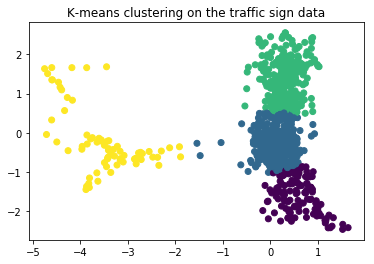

In [112]:
slow_features = slow_feature_analysis(X, 2)
#slow_features = slow_features[:100, :]
classes = k_means(slow_features, ini_clusters, threshold=0.001)
plt.scatter(slow_features[:,0], slow_features[:,1], c=classes)
plt.title("K-means clustering on the traffic sign data")
plt.show()